In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import check_array
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\Users\cf660\AppData\Local\Temp\ipykernel_7852\474223218.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Setup Mortality Dataset

In [3]:
url = 'https://github.com/suinleelab/treexplainer-study/raw/master/data/mortality_data.csv'
df = pd.read_csv(url)
df

HTTPError: HTTP Error 404: Not Found

In [2]:
diabetes_data = load_diabetes()
X_data, y_data = diabetes_data.data, diabetes_data.target
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
feature_name_mappings = {}
for i in range(len(diabetes_data.feature_names)):
    feature_name_mappings[i] = diabetes_data.feature_names[i]
feature_name_mappings

{0: 'age',
 1: 'sex',
 2: 'bmi',
 3: 'bp',
 4: 's1',
 5: 's2',
 6: 's3',
 7: 's4',
 8: 's5',
 9: 's6'}

In [3]:
from feature_tracker import CustomGBR
# Train CustomGBR
gbr = CustomGBR(n_estimators=10, learning_rate=0.1, max_depth=3)
gbr.fit(X_train, y_train)

CustomGBR(n_estimators=10)

#### Logic behind the tree structure: Lower than threshold -> go to left node, vice versa.

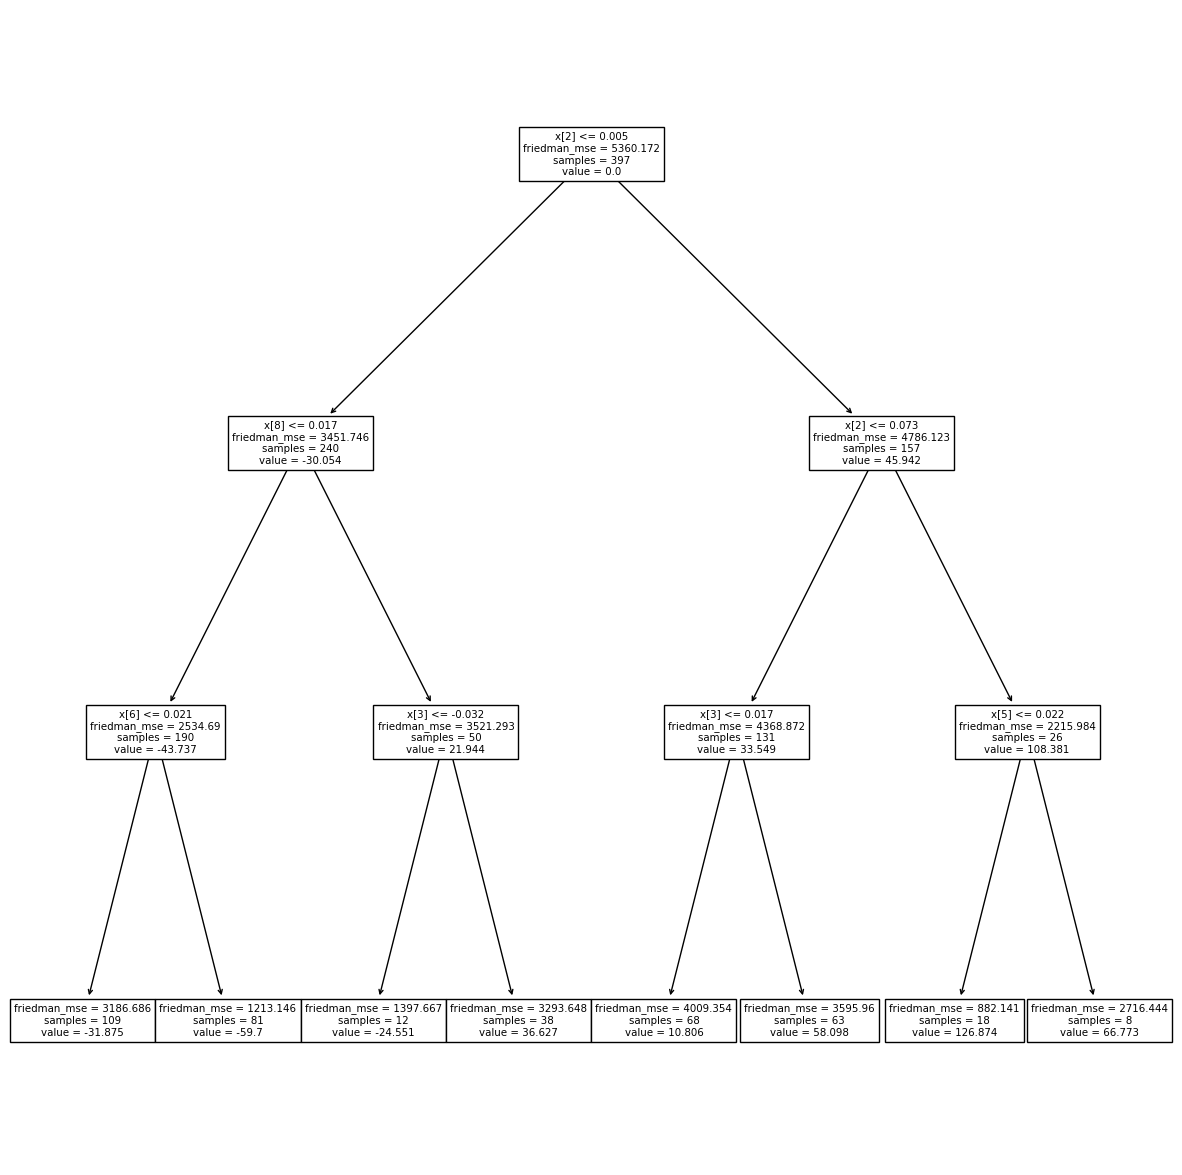

In [4]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 15))
plot_tree(gbr.estimators_[1][0])
plt.show()


#### Feature Importance Trends

In [5]:
feature_importances_per_iter = gbr.get_feature_importance_per_iteration()
feature_importances_per_iter = feature_importances_per_iter.rename(columns=feature_name_mappings)
feature_importances_per_iter

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,65.278550,0.0,826.668976,0.000000,0.000000,53.106120,65.158692,0.000000,1685.597281,190.331907
1,0.000000,0.0,1686.729333,270.213341,0.000000,50.391641,90.623579,0.000000,430.134248,0.000000
2,0.000000,0.0,620.884608,149.130653,0.000000,59.753932,0.000000,0.000000,1216.271710,0.000000
3,0.000000,0.0,610.005317,72.841279,0.000000,51.259546,0.000000,0.000000,993.143718,0.000000
4,51.232722,0.0,379.358830,0.000000,26.706038,47.787256,0.000000,0.000000,763.474176,123.787743
5,0.000000,0.0,632.668176,201.335034,0.000000,0.000000,0.000000,215.937319,185.054131,102.374583
6,0.000000,0.0,281.701591,51.261153,0.000000,37.824776,0.000000,0.000000,551.930774,77.288608
7,24.229536,0.0,552.894395,90.150379,0.000000,0.000000,0.000000,150.363244,69.769489,38.763181
8,0.000000,0.0,139.255103,138.660169,0.000000,14.873119,88.740998,83.025352,353.777667,0.000000
9,36.109361,0.0,388.416567,0.000000,66.133010,20.166346,0.000000,0.000000,172.382113,0.000000


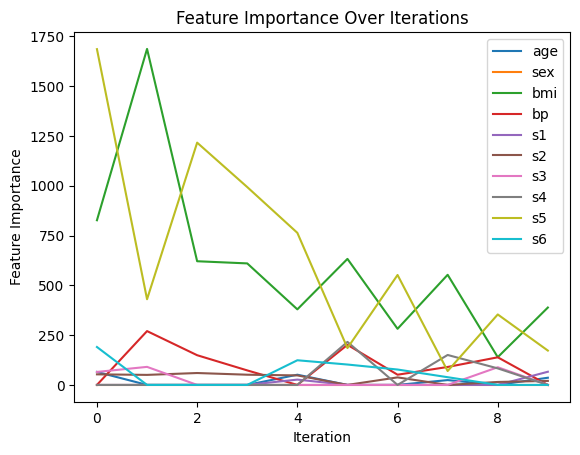

In [6]:
# Assuming 'feature_importances_per_iter' is the matrix obtained from the custom method
for feature_idx in range(len(feature_importances_per_iter.columns)):
    plt.plot(feature_importances_per_iter.iloc[:, feature_idx], label=feature_importances_per_iter.columns[feature_idx])

plt.xlabel('Iteration')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Over Iterations')
plt.legend()
plt.show()

We can estimate each feature's curve with a function, and perhaps come up with a gradient at a certain point for each feature. If the gradient stops increasing after n rounds of boosting, it can be an additional stopping criteria for professionals.

#### Feature Impact Tracking

In [7]:
feature_impacts_per_iter = gbr.get_feature_impacts_per_iteration()
feature_impacts_per_iter['feature'] = feature_impacts_per_iter['feature'].apply(lambda x: feature_name_mappings[x])
feature_impacts_per_iter

,iteration,feature,threshold,impact,samples
0,1,s5,-0.003761,-8.211857,397
1,1,bmi,0.006189,-6.610769,196
2,1,s3,0.021028,2.577333,156
3,1,age,-0.079982,11.678947,40
4,1,bmi,0.068702,-8.993614,201
...,...,...,...,...,...
65,10,age,0.028995,-2.033473,196
66,10,s1,0.074796,6.333365,44
67,10,bmi,0.073013,-3.958449,157
68,10,s5,0.063671,-4.052013,131


##### Feature Impact Tracking Per Iteration

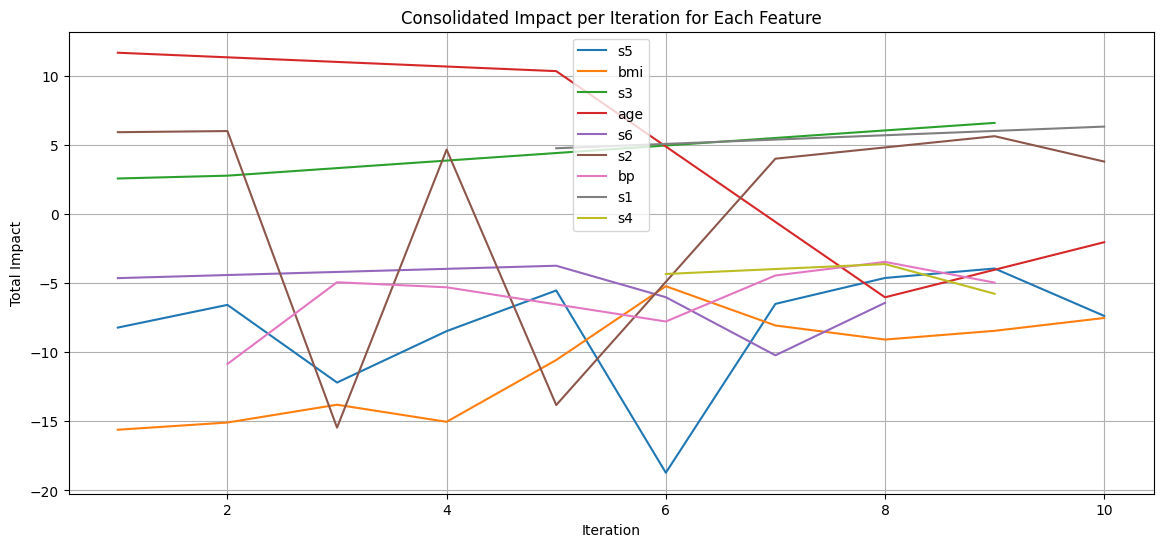

In [8]:
plt.figure(figsize=(14, 6))
for feature in feature_impacts_per_iter['feature'].unique():
    df_feature = feature_impacts_per_iter[feature_impacts_per_iter['feature'] == feature]
    impact_per_iteration = df_feature.groupby('iteration')['impact'].sum()
    plt.plot(impact_per_iteration.index, impact_per_iteration, label=feature)
plt.title('Consolidated Impact per Iteration for Each Feature')
plt.xlabel('Iteration')
plt.ylabel('Total Impact')
plt.legend()
plt.grid(True)
plt.show()

##### Feature Impact Tracking Per Iteration (Weighted by Samples)

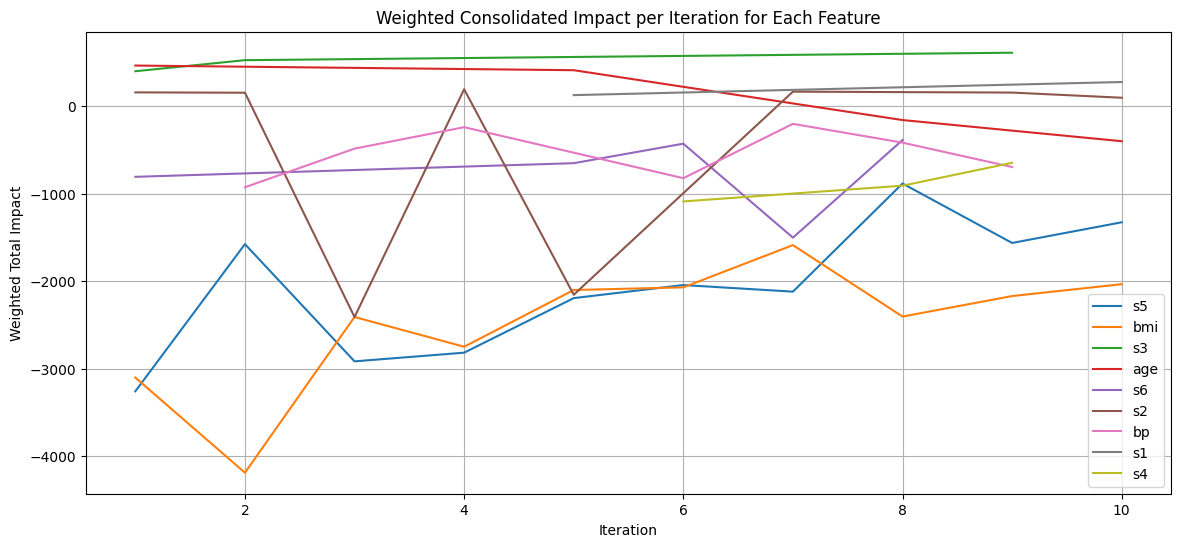

In [11]:
plt.figure(figsize=(14, 6))
for feature in feature_impacts_per_iter['feature'].unique():
    df_feature = pd.DataFrame(feature_impacts_per_iter[feature_impacts_per_iter['feature'] == feature])
    df_feature['weighted_impact'] = df_feature['impact'] * df_feature['samples']
    weighted_impact_per_iteration = df_feature.groupby('iteration')['weighted_impact'].sum()
    plt.plot(weighted_impact_per_iteration.index, weighted_impact_per_iteration, label=feature)
plt.title('Weighted Consolidated Impact per Iteration for Each Feature')
plt.xlabel('Iteration')
plt.ylabel('Weighted Total Impact')
plt.legend()
plt.grid(True)
plt.show()

##### Consolidated Feature Impacts

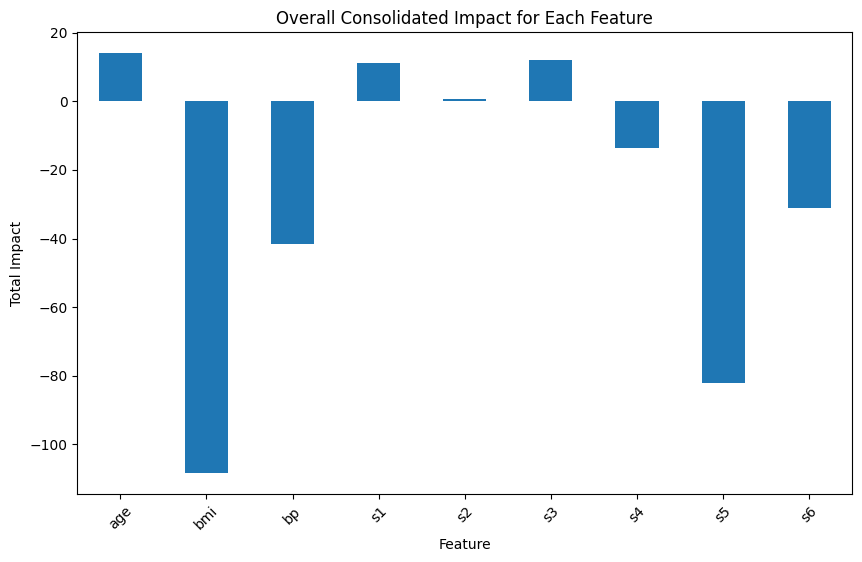

In [12]:
df_grouped = feature_impacts_per_iter.groupby('feature')['impact'].sum()
plt.figure(figsize=(10, 6))
df_grouped.plot(kind='bar')
plt.title('Overall Consolidated Impact for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Total Impact')
plt.xticks(rotation=45)
plt.show()

##### Consolidated Feature Impacts (Weighted by Samples)

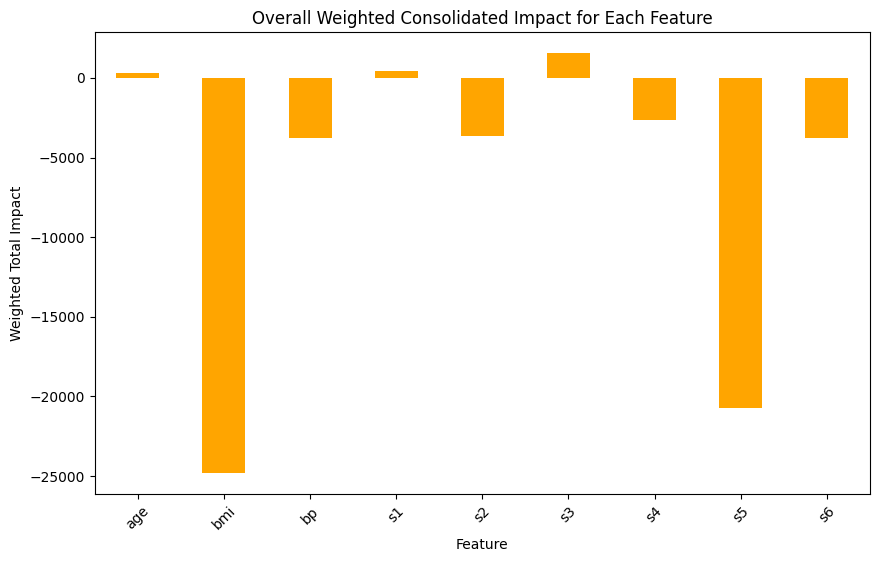

In [13]:
feature_impacts_per_iter['weighted_impact'] = feature_impacts_per_iter['impact'] * feature_impacts_per_iter['samples']
df_weighted_grouped = feature_impacts_per_iter.groupby('feature')['weighted_impact'].sum()
plt.figure(figsize=(10, 6))
df_weighted_grouped.plot(kind='bar', color='orange')
plt.title('Overall Weighted Consolidated Impact for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Weighted Total Impact')
plt.xticks(rotation=45)
plt.show()

##### Consolidated Directional Feature Impacts

In [17]:
feature_impacts_per_iter['impact_direction'] = feature_impacts_per_iter['impact'].apply(lambda x: 1 if x >= 0 else -1)
feature_impacts_per_iter

,iteration,feature,threshold,impact,samples,weighted_impact,impact_direction
0,1,s5,-0.003761,-8.211857,397,-3260.107044,-1
1,1,bmi,0.006189,-6.610769,196,-1295.710769,-1
2,1,s3,0.021028,2.577333,156,402.064000,1
3,1,age,-0.079982,11.678947,40,467.157895,1
4,1,bmi,0.068702,-8.993614,201,-1807.716475,-1
...,...,...,...,...,...,...,...
65,10,age,0.028995,-2.033473,196,-398.560751,-1
66,10,s1,0.074796,6.333365,44,278.668045,1
67,10,bmi,0.073013,-3.958449,157,-621.476447,-1
68,10,s5,0.063671,-4.052013,131,-530.813662,-1


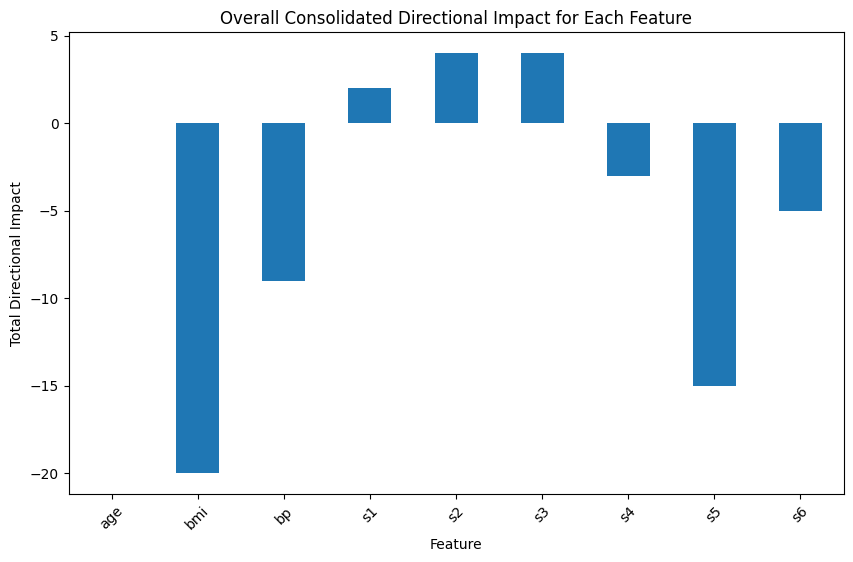

In [18]:
df_directional_grouped = feature_impacts_per_iter.groupby('feature')['impact_direction'].sum()
plt.figure(figsize=(10, 6))
df_directional_grouped.plot(kind='bar')
plt.title('Overall Consolidated Directional Impact for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Total Directional Impact')
plt.xticks(rotation=45)
plt.show()

##### Feature Impact Scores (Proportion of Positive/Negative Impacts)

In [20]:
# Calculate the sum of absolute impacts per feature
sum_abs_impacts = feature_impacts_per_iter.groupby('feature')['impact'].apply(lambda x: x.abs().sum())

# Calculate the sum of positive impacts per feature
sum_pos_impacts = feature_impacts_per_iter[feature_impacts_per_iter['impact'] >= 0].groupby('feature')['impact'].sum()

# Calculate the sum of negative impacts per feature
sum_neg_impacts = feature_impacts_per_iter[feature_impacts_per_iter['impact'] < 0].groupby('feature')['impact'].sum()

# Proportion of positive impacts per feature
prop_pos_impacts = sum_pos_impacts / sum_abs_impacts

# Proportion of negative impacts per feature (taking absolute value of negative impacts)
prop_neg_impacts = sum_neg_impacts.abs() / sum_abs_impacts
impact_scores_df = pd.DataFrame({
    'Proportion of Positive Impacts': prop_pos_impacts,
    'Proportion of Negative Impacts': prop_neg_impacts
}).fillna(0) 
impact_scores_df

,Proportion of Positive Impacts,Proportion of Negative Impacts
feature,,
age,0.732244,0.267756
bmi,0.000000,1.000000
bp,0.000000,1.000000
s1,1.000000,0.000000
s2,0.506652,0.493348
s3,1.000000,0.000000
s4,0.000000,1.000000
s5,0.000000,1.000000
s6,0.000000,1.000000


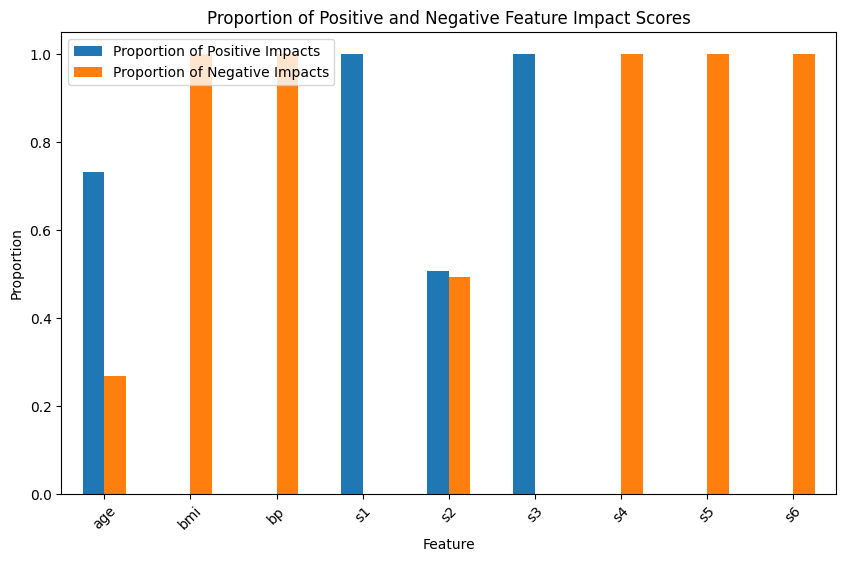

In [21]:
impact_scores_df.plot(kind='bar', figsize=(10, 6))
plt.title('Proportion of Positive and Negative Feature Impact Scores')
plt.xlabel('Feature')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()

##### Directional Feature Impact Scores

In [22]:
# Calculate the sum of absolute directional impacts per feature
sum_abs_impacts_dir = feature_impacts_per_iter.groupby('feature')['impact_direction'].apply(lambda x: x.abs().sum())

# Calculate the sum of positive directional impacts per feature
sum_pos_impacts_dir = feature_impacts_per_iter[feature_impacts_per_iter['impact_direction'] >= 0].groupby('feature')['impact_direction'].sum()

# Calculate the sum of negative directional impacts per feature
sum_neg_impacts_dir = feature_impacts_per_iter[feature_impacts_per_iter['impact_direction'] < 0].groupby('feature')['impact_direction'].sum()

# Proportion of positive directional impacts per feature
prop_pos_impacts_dir = sum_pos_impacts_dir / sum_abs_impacts_dir

# Proportion of negative directional impacts per feature
prop_neg_impacts_dir = sum_neg_impacts_dir.abs() / sum_abs_impacts_dir
impact_dir_scores_df = pd.DataFrame({
    'Proportion of Positive Directional Impacts': prop_pos_impacts_dir,
    'Proportion of Negative Directional Impacts': prop_neg_impacts_dir
}).fillna(0) 
impact_dir_scores_df

,Proportion of Positive Directional Impacts,Proportion of Negative Directional Impacts
feature,,
age,0.50,0.50
bmi,0.00,1.00
bp,0.00,1.00
s1,1.00,0.00
s2,0.75,0.25
s3,1.00,0.00
s4,0.00,1.00
s5,0.00,1.00
s6,0.00,1.00


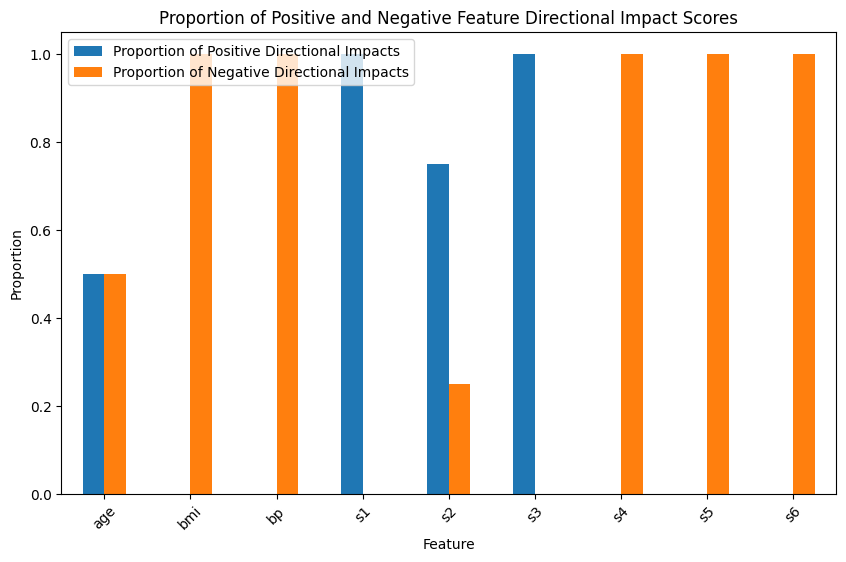

In [23]:
impact_dir_scores_df.plot(kind='bar', figsize=(10, 6))
plt.title('Proportion of Positive and Negative Feature Directional Impact Scores')
plt.xlabel('Feature')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()